In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pystan as ps
import utils as utils
# Set my plot theme
# See here for more detials
# https://github.com/RishiSadhir/rethinking2/blob/master/utils/plotting.py
#utils.set_theme()
COLOR = "#2A0933"

In [3]:
%load_ext jupyterstan

# 7.1 The problem with parameters

In [4]:
d = pd.DataFrame({
    "species": ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"],
    "brain": [483, 452, 612, 521, 752, 871, 1350],
    "mass": [37, 35.5, 34.5, 41.5, 55.5, 61, 53.5]})
d["mass_std"] = (d["mass"] - np.mean(d["mass"]))/np.std(d["mass"])
d['brain_std'] = d['brain'] / np.max(d['brain'])
d

,species,brain,mass,mass_std,brain_std
0,afarensis,483,37.0,-0.841920,0.357778
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


In [5]:
%%stan m_overfit
data {
  int N;
  int K;
  matrix[N, K] X;
  vector[N] y;
}
parameters {
  vector[K] b;
  real log_sigma;
}
model {
  b[1] ~ normal(.5, 1);
  b[2:K] ~ normal(0, 10);
  log_sigma ~ normal(0, 1);
  y ~ normal(X*b, exp(log_sigma));
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_overfit_9424bd8fcc33cb32d1ddc9afd442ea9b NOW.


Creating pystan model & assigning it to variable name "m_overfit".
Stan options:
 {'model_name': 'm_overfit', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_overfit"!
Compilation took 39 seconds.


In [12]:

m_overfit.sampling(d_dict)

Inference for Stan model: m_overfit_9424bd8fcc33cb32d1ddc9afd442ea9b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]        0.54  2.1e-3    0.1   0.33   0.47   0.54   0.59   0.75   2331    1.0
b[2]        0.15  2.1e-3    0.1  -0.07   0.09   0.15   0.21   0.36   2402    1.0
log_sigma  -1.41  8.9e-3   0.37  -2.03  -1.68  -1.45  -1.18  -0.61   1701    1.0
lp__        6.02    0.04   1.48   2.19   5.24   6.38   7.14   7.77   1120    1.0

Samples were drawn using NUTS at Sat May  9 18:10:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [123]:
d_dict = {
    "N": len(d.index),
    "K": 2,
    "X": np.transpose([np.ones(len(d.index)), d['mass_std'].values]),
    "y": d["brain_std"]
}
def gen_design_matrix(xseq, K):
    N = len(xseq)
    X = np.empty((N, K))
    X[:,0] = np.ones(N)
    for j in range(1, K):
        X[:,j] = np.power(xseq,j)
    return X

def predict(fit, X_new, alpha = .05):
    b = fit.extract("b")["b"]
    post_yhat = np.matmul(X_new, np.transpose(b))
    yhat = np.apply_along_axis(np.mean, 1, post_yhat)
    yhat_bounds = np.apply_along_axis(utils.hpdi, 1, post_yhat)
    return (yhat, yhat_bounds[:,0], yhat_bounds[:,1])
    
degree = 6
xseq = np.linspace(min(d['mass_std']), max(d['mass_std']), 100)
fits = []
N = len(d.index)
for i in range(degree+1):
    X = gen_design_matrix(d['mass_std'], i+1)
    d_dict["X"] = X
    d_dict["K"] = X.shape[1]
    fit = m_overfit.sampling(d_dict, n_jobs=4, control = {"adapt_delta": .99, "max_treedepth": 15})
    fits.append(fit)

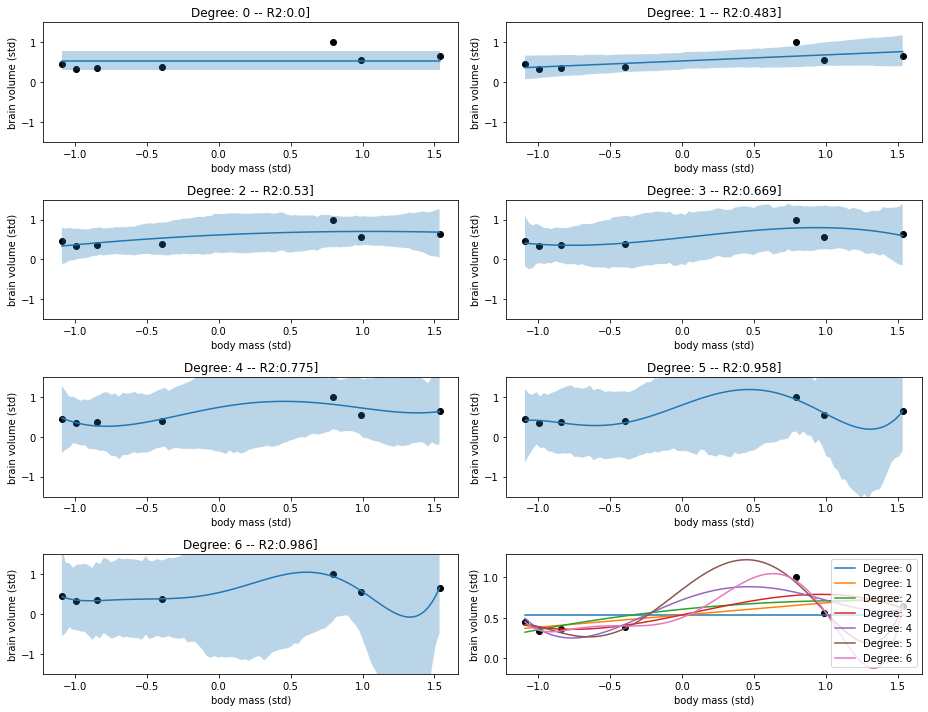

In [138]:
def r2(y, yhat):
    r = yhat - y
    return (1 - (np.var(r)/np.var(y)))

fig, ax = plt.subplots(figsize = (13, 10), nrows = 4, ncols = 2)
ax[3,1].scatter(d.mass_std, d.brain_std, color = "black")
for i in range(7):
    ax[3,1].plot(xseq, np.apply_along_axis(np.mean, 1, yhats[i]), label = f"Degree: {i}")
    ax[3, 1].set_xlabel("body mass (std)")
    ax[3, 1].set_ylabel("brain volume (std)")
ax[3,1].legend()

for i in range(7):
    y = i % 2
    x = int(i / 2)
    yhat, yhat_low, yhat_high = predict(fits[i], gen_design_matrix(xseq, i+1))
    y_retrodict,_,_ = predict(fits[i], gen_design_matrix(d.mass_std, i+1))
    ax[x, y].scatter(d.mass_std, d.brain_std, color = "black")
    ax[x, y].plot(xseq, yhat, label = f"Degree: {i}")
    ax[x, y].fill_between(xseq, yhat_low, yhat_high, alpha = .3)
    ax[x, y].set_xlabel("body mass (std)")
    ax[x, y].set_ylabel("brain volume (std)")
    ax[x, y].set_title(f"Degree: {i} -- R2:{round(r2(d.brain_std, y_retrodict),3)}]")
    ax[x, y].set_ylim([-1.5, 1.5])
fig.tight_layout()
plt.show()

In [172]:
fit = {}
for degree in [2, 6]:
    fit[degree] = {}
    for i in range(len(d.index)):
        df = d.drop(index=i)
        d_dict = {
            "N": len(df.index),
            "K": degree,
            "X": gen_design_matrix(df["mass_std"], degree),
            "y": df["brain_std"]}
        fit[degree][i] = m_overfit.sampling(d_dict, n_jobs=4, control = {"adapt_delta": .99, "max_treedepth": 15})
fit

{2: {0: Inference for Stan model: m_overfit_9424bd8fcc33cb32d1ddc9afd442ea9b.
  4 chains, each with iter=2000; warmup=1000; thin=1; 
  post-warmup draws per chain=1000, total post-warmup draws=4000.
  
              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
  b[1]        0.54  3.8e-3   0.14   0.26   0.47   0.54   0.62   0.84   1446    1.0
  b[2]        0.15  3.2e-3   0.14  -0.13   0.07   0.14   0.21   0.45   2007    1.0
  log_sigma  -1.25    0.01   0.43  -1.97  -1.56  -1.29  -0.99   -0.3    894   1.01
  lp__        4.24    0.06   1.68   0.02   3.49   4.68   5.44   6.12    676   1.01
  
  Samples were drawn using NUTS at Sat May  9 19:14:31 2020.
  For each parameter, n_eff is a crude measure of effective sample size,
  and Rhat is the potential scale reduction factor on split chains (at 
  convergence, Rhat=1).,
  1: Inference for Stan model: m_overfit_9424bd8fcc33cb32d1ddc9afd442ea9b.
  4 chains, each with iter=2000; warmup=1000; thin=1; 
  post-warmup draws

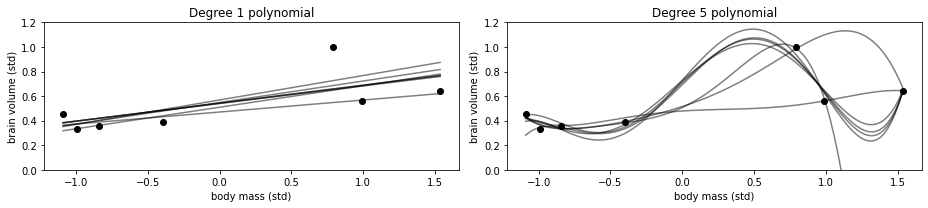

In [186]:
fig, ax = plt.subplots(figsize = (13,3), ncols = 2)
ax[0].scatter(d.mass_std, d.brain_std, color = "black")
ax[0].set_ylim([0,1.2])
ax[0].set_xlabel("body mass (std)")
ax[0].set_ylabel("brain volume (std)")
ax[0].set_title("Degree 1 polynomial")
ax[1].scatter(d.mass_std, d.brain_std, color = "black")
ax[1].set_ylim([0,1.2])
ax[1].set_xlabel("body mass (std)")
ax[1].set_ylabel("brain volume (std)")
ax[1].set_title("Degree 5 polynomial")
for i in range(len(d.index)):
    model = fit[2][i]
    yhat,_,_ = predict(model, gen_design_matrix(xseq, 2))
    ax[0].plot(xseq, yhat, color = "black", alpha = .5)
for i in range(len(d.index)):
    model = fit[6][i]
    yhat,_,_ = predict(model, gen_design_matrix(xseq, 6))
    ax[1].plot(xseq, yhat, color = "black", alpha = .5)
    
fig.tight_layout()
plt.show()

# 7.2 - Entropy and Accuracy